# Differentially Private Covariance

WhiteNoise offers three different functionalities within its `covariance` function:

1. Covariance between two vectors
2. Covariance matrix of a matrix
3. Cross-covariance matrix of a pair of matrices, where element $(i,j)$ of the returned matrix is the covariance of column $i$ of the left matrix and column $j$ of the right matrix.

In [13]:
# load libraries
import os
import whitenoise
import whitenoise.components as op
import numpy as np

# establish data information
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married"]

data = np.genfromtxt(data_path, delimiter=',', names=True)

### Functionality

Below we show the relationship between the three methods by calculating the same covariance in each. We use a much larger $\epsilon$ than would ever be used in practice to show that the methods are consistent with one another.   

In [55]:
with whitenoise.Analysis() as analysis:
    wn_data = whitenoise.Dataset(path = data_path, column_names = var_names)
    
    # get scalar covariance
    age_income_cov_scalar = op.dp_covariance(left = op.cast(wn_data['age'], type="FLOAT"),
                                        right = op.cast(wn_data['income'], type="FLOAT"),
                                        privacy_usage = {'epsilon': 5000},
                                        left_min = 0.,
                                        left_max = 100.,
                                        left_n = 1000,
                                        right_min = 0.,
                                        right_max = 500_000.,
                                        right_n = 1000)
    
    # get full covariance matrix
    age_income_cov_matrix = op.dp_covariance(data = op.cast(wn_data['age', 'income'], type = "FLOAT"),
                                           privacy_usage = {'epsilon': 5000},
                                           data_min = [0., 0.],
                                           data_max = [100., 500_000.],
                                           data_n = 1000)

    # get cross-covariance matrix
    cross_covar = op.dp_covariance(left = op.cast(wn_data['age', 'income'], type = "FLOAT"),
                                   right = op.cast(wn_data['age', 'income'], type = "FLOAT"),
                                   privacy_usage = {'epsilon': 5000},
                                   left_min = [0., 0.],
                                   left_max = [100., 500_000.],
                                   left_n = 1_000,
                                   right_min = [0., 0.],
                                   right_max = [100., 500_000.],
                                   right_n = 1000)

analysis.release()
print('scalar covariance:\n{0}\n'.format(age_income_cov_scalar.value))
print('covariance matrix:\n{0}\n'.format(age_income_cov_matrix.value))    
print('cross-covariance matrix:\n{0}'.format(cross_covar.value))

scalar covariance:
[[94583.47140261]]

covariance matrix:
[[3.14864991e+02 9.45933004e+04]
 [9.45933004e+04 2.65135256e+09]]

cross-covariance matrix:
[[3.14852074e+02 9.45933004e+04]
 [9.45933004e+04 2.65135256e+09]]


### DP Covariance in Practice
  
We now move to an example with a more reasonable $\epsilon$. 

In [56]:
with whitenoise.Analysis() as analysis:
    wn_data = whitenoise.Dataset(path = data_path, column_names = var_names)
    # get full covariance matrix
    cov = op.dp_covariance(data = op.cast(wn_data['age', 'sex', 'income', 'married'], type = "FLOAT"),
                                          privacy_usage = {'epsilon': 0.3},
                                          data_min = [0., 0., 0., 0.],
                                          data_max = [100., 1., 500_000., 1.],
                                          data_n = 1000)
analysis.release()

# store DP covariance matrix and get correlation matrix
dp_cov = cov.value
dp_corr = dp_cov / np.outer(np.sqrt(np.diag(dp_cov)), np.sqrt(np.diag(dp_cov)))

# get non-DP covariance/correlation matrices
age = list(data[:]['age'])
sex = list(data[:]['sex'])
income = list(data[:]['income'])
married = list(data[:]['married'])
non_dp_cov = np.cov([age, sex, income, married])
non_dp_corr = non_dp_cov / np.outer(np.sqrt(np.diag(non_dp_cov)), np.sqrt(np.diag(non_dp_cov)))

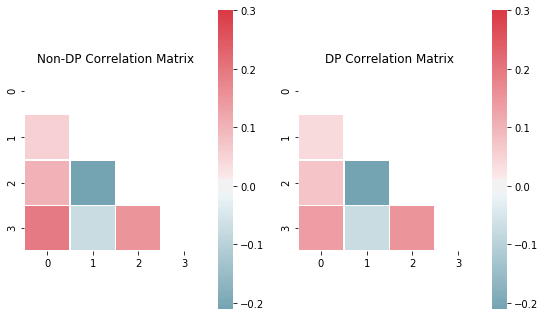

In [60]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize = (9, 11))

# generate a mask for the upper triangular matrix
mask = np.triu(np.ones_like(non_dp_corr, dtype=np.bool))

# generate color palette
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# get correlation plots
ax_1.title.set_text('Non-DP Correlation Matrix')
sns.heatmap(non_dp_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax_1)
ax_2.title.set_text('DP Correlation Matrix')
sns.heatmap(dp_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax_2)
